In [1]:
# Import libraries
import warnings
import pandas as pd
import psutil
import sklearn
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Data Preprocessing

In [2]:
# Load the dataset
df = pd.read_csv('data/monthly-sunspots.csv')
df.head()

Month  Sunspots
0  1749-01      58.0
1  1749-02      62.6
2  1749-03      70.0
3  1749-04      55.7
4  1749-05      85.0

In [3]:
df.shape

(2820, 2)

In [4]:
# convert the date column to datetime
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
df.head()

Month  Sunspots
0 1749-01-01      58.0
1 1749-02-01      62.6
2 1749-03-01      70.0
3 1749-04-01      55.7
4 1749-05-01      85.0

In [5]:
df.tail()

Month  Sunspots
2815 1983-08-01      71.8
2816 1983-09-01      50.3
2817 1983-10-01      55.8
2818 1983-11-01      33.3
2819 1983-12-01      33.4

In [6]:
df.sort_values(by='Month', inplace=False).tail()

Month  Sunspots
2815 1983-08-01      71.8
2816 1983-09-01      50.3
2817 1983-10-01      55.8
2818 1983-11-01      33.3
2819 1983-12-01      33.4

In [7]:
df.Sunspots.sum()

144570.0

In [8]:
# sum by years
df_grouped = df.groupby(pd.Grouper(key='Month', freq='Y')).sum()

df_grouped.head()

Sunspots
Month               
1749-12-31     971.1
1750-12-31    1000.7
1751-12-31     571.9
1752-12-31     573.6
1753-12-31     368.3

In [9]:
# set the date column as the index
df_indexed = df.set_index('Month', inplace=False)

The data is already ordered by date. The first date is 1749-01-01 and the last is 1983-12-01. The sample is a month with its number of Sunspots registered. The data is a time series.

The sunspot number is a float, this means that is either an average or it keeps track of partial sunspots that end/start in a different month. Probably the latter since the total number of sunspots is an integer. But we can't be sure. This shouldn't matter for our model training anyway. Also, the total number is even probably because the sunspots appears in pairs. This could be useful for our model.

_Sunspots are temporary phenomena on the Sun's photosphere that appear as spots darker than the surrounding areas. They are regions of reduced surface temperature caused by concentrations of magnetic field flux that inhibit convection. Sunspots usually appear in pairs of opposite magnetic polarity. Their number varies according to the approximately 11-year solar cycle._

_The sunspot number is a crucial component of space weather. It is a measure of solar activity, and the number of sunspots on the solar surface changes over the course of the solar cycle. The solar cycle is a periodic change in the sun's activity and appearance. The cycle is about 11 years long on average. The solar cycle is marked by the increase and decrease of sunspots on the sun's surface. During the solar maximum, large numbers of sunspots appear, and during the solar minimum, very few sunspots appear. The solar cycle affects space weather, which can affect satellites and astronauts in space. The solar cycle is also responsible for the aurora borealis, or Northern Lights, in the Northern Hemisphere. The solar cycle was discovered in 1843 by Samuel Heinrich Schwabe, who noticed that the number of sunspots visible on the sun's surface changed over time. The solar cycle is also known as the sunspot cycle or the Schwabe cycle._

In [10]:
df_indexed.describe()

Sunspots
count  2820.000000
mean     51.265957
std      43.448971
min       0.000000
25%      15.700000
50%      42.000000
75%      74.925000
max     253.800000

The

In [11]:
df_indexed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2820 entries, 1749-01-01 to 1983-12-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sunspots  2820 non-null   float64
dtypes: float64(1)
memory usage: 44.1 KB


THere is no missing values in the dataset.

<Axes: xlabel='Sunspots'>

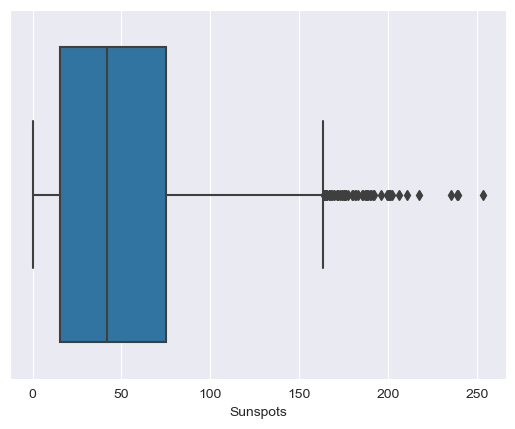

In [12]:
# print a boxplot
sns.boxplot(x=df_indexed['Sunspots'])

Also, no extreme values are present.

# Data Visualization

Since the data is a time series, we can plot the data to see how the sunspots have changed over time. I will use the seaborn library to plot the data. Since the result is better than matplotlib.

- Trend Component: It represents the long-term pattern or trend in the data. It shows the overall direction or tendency of the data over an extended period. The trend component indicates whether the series is increasing, decreasing, or remaining relatively stable.

- Seasonal Component: It represents the repetitive pattern or seasonality in the data. It captures the periodic fluctuations that occur over a specific time period, such as daily, weekly, or yearly patterns.

- Residual Component: It represents the remaining or leftover variation in the data after removing the seasonal and trend components. It consists of the random fluctuations, noise, or irregularities that cannot be explained by the seasonal or trend patterns.

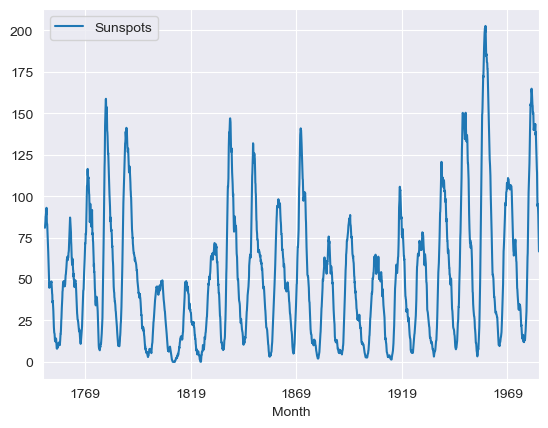

In [13]:
# get rolling mean on a year basis
rolling_mean = df_indexed.rolling(window=12).mean().plot()

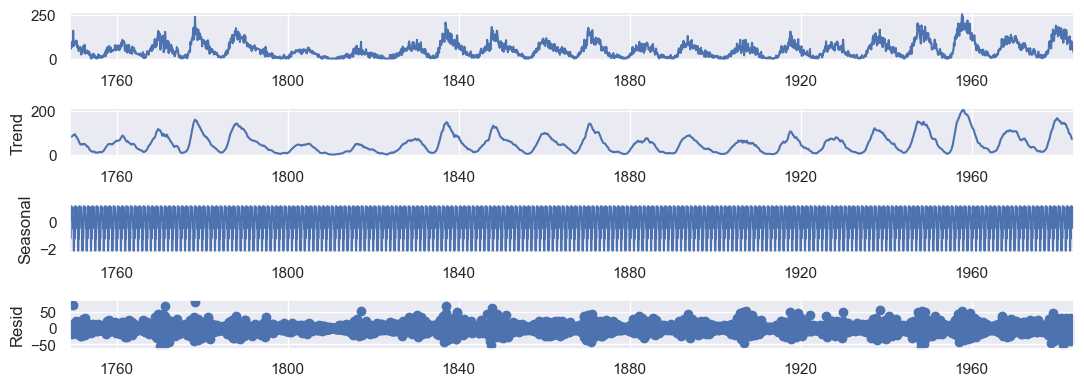

In [14]:
result = seasonal_decompose(df_indexed, model='additive')
sns.set(rc={'figure.figsize':(11, 4)})
ax = result.plot()

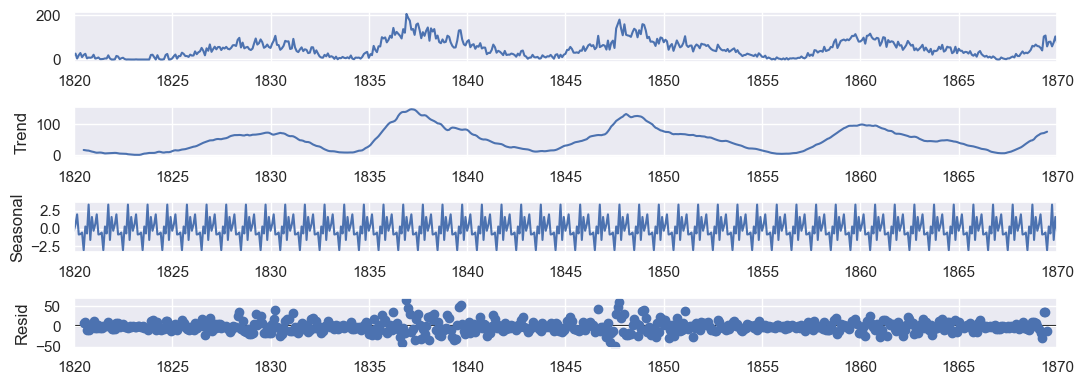

In [15]:
# same but in a shorted range
df_short = df_indexed['1820-01-01':'1870-01-01']
result = seasonal_decompose(df_short, model='additive')
sns.set(rc={'figure.figsize':(11, 4)})
ax = result.plot()

We can see a *trend* which start at 0 sunspots and increase to some number of sunspots. Then it decrease to 0 sunspots again. Graphically, this is a cycle seems to be around 10 years. We know that it is 11 years.

The *seasonal* component has a variance between -2.5 and 2.5.

The *residual* component is the noise around the trend and seasonal component.

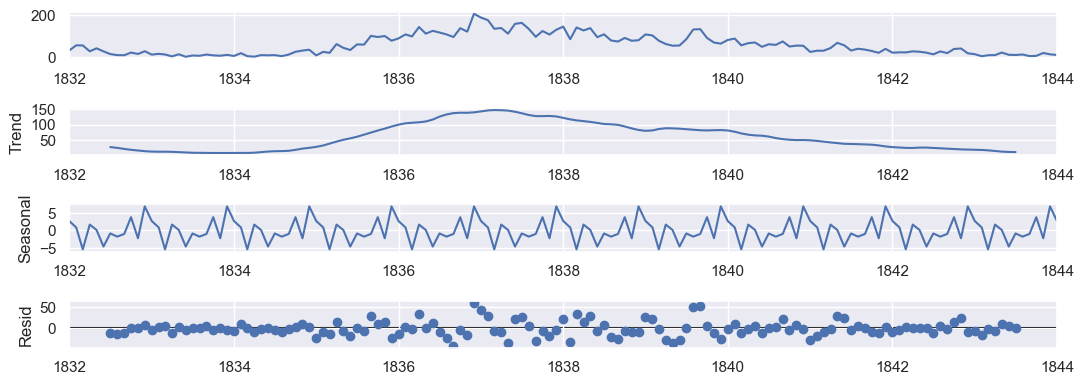

In [16]:
# zooming a specific trend
df_trend = df_indexed['1832-01-01':'1844-01-01']
result = seasonal_decompose(df_trend, model='additive')
# plot with sns
sns.set(rc={'figure.figsize':(11, 4)})
ax = result.plot()

The residual component is the noise around the trend and seasonal component. It is vary between -50 and 50.

# Fourier Transform

Apply the Fourier transformation and find the periodicity of the data.

The Fourier transform is a mathematical function that takes a time-based pattern as input and determines the overall cycle offset, rotation speed, and strength for every possible cycle in the given pattern. The Fourier transform is used to find the cyclic patterns hidden in the time series data.

I will calculate the periodicity on the train set to avoid test bias.

In [17]:
df_train = df_indexed['1749-01-01':'1919-12-01']
df_test = df_indexed['1920-01-01':'1983-12-01']

df_train.shape, df_test.shape

((2052, 1), (768, 1))

In [18]:
# Apply Fourier transformation
fourier_transform = np.fft.fft(df_train['Sunspots'])
fourier_transform.shape

(2052,)

In [19]:
fourier_transform[0:10]

array([93338.8           +0.j        ,  1468.1036331   -212.88095452j,
       -1264.72141466-17793.04535383j, -7928.54620491 +6239.67068341j,
        7122.83407343 +3535.55795089j,   555.94555365  +206.05242238j,
        3791.90814354 -5119.83490291j,  1853.86932136 +4123.29141588j,
        3675.5880518  +5597.02967995j,   963.21680018 -2620.91520629j])

In [20]:
# Compute the frequencies corresponding to the Fourier coefficients
n = len(df_train['Sunspots'])
frequencies = np.fft.fftfreq(n)

frequencies.shape

(2052,)

In [21]:
frequencies[0:10]

array([0.        , 0.00048733, 0.00097466, 0.00146199, 0.00194932,
       0.00243665, 0.00292398, 0.00341131, 0.00389864, 0.00438596])

In [22]:
# Find the periodicity (frequency with the highest amplitude)
periodicity = np.abs(frequencies[np.argmax(np.abs(fourier_transform))])
print('Periodicity =', periodicity)

Periodicity = 0.0


In [23]:
print(f"Periodicity: {1 / periodicity} time units")

Periodicity: inf time units


C:\Users\Administrator\AppData\Local\Temp\ipykernel_82340\2936873598.py:1: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"Periodicity: {1 / periodicity} time units")


A periodicity of "infinite" is not what we would expect.

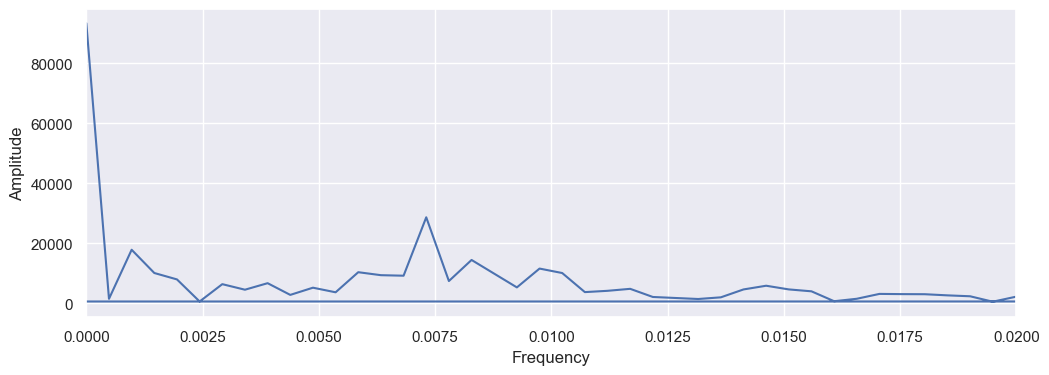

In [24]:
# Plot the Fourier transform
plt.figure(figsize=(12, 4))
plt.plot(frequencies, np.abs(fourier_transform))
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.xlim(0, 0.02)
plt.show()

The code return a very high periodicity near 0. But this is wrong, the periodicity we want is the second peak we see. so I will recalculate the argmax but ignoring the first peak.

In [25]:
# Find the periodicity (frequency with the highest amplitude)
threshold = 5

max_index = np.argmax(np.abs(fourier_transform[threshold:])) + threshold

periodicity = 1 / np.abs(frequencies[max_index])

print('Periodicity =', periodicity)

Periodicity = 136.8


This means a periodicity if 136.8 months. Which is 11.4 years. This is the expected periodicity of the sunspots.

For the future engineering, I will use the periodicity of 11.4 years.

I will also calculate the periodicity of the seasonality.


<Axes: xlabel='Month'>

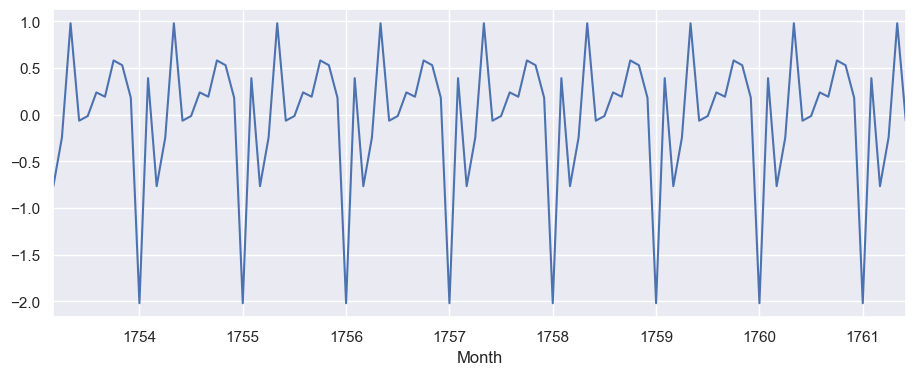

In [26]:
# Plot the Fourier transform but this time only for the seasonality
result_season = seasonal_decompose(df_train, model='additive').seasonal
result_season.iloc[50:150].plot()

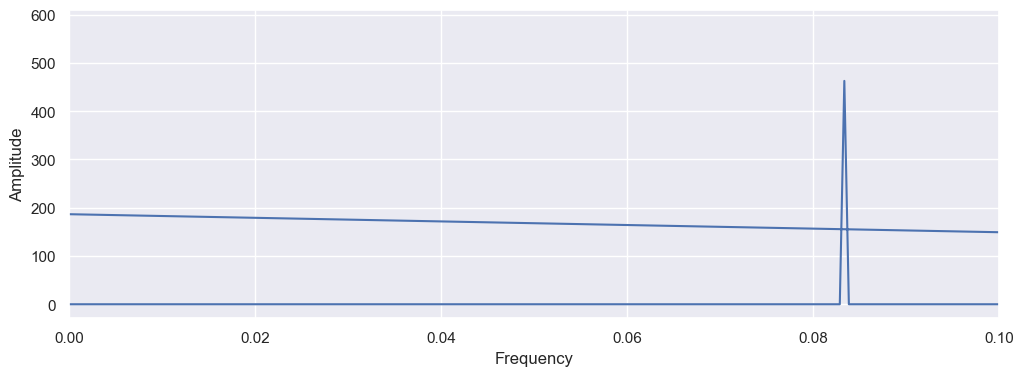

In [27]:
n_season = len(result_season)
frequencies_season = np.fft.fftfreq(n_season)

fourier_transform_season = np.fft.fft(result_season)

plt.figure(figsize=(12, 4))
plt.plot(frequencies_season, np.abs(fourier_transform_season))
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.xlim(0, 0.1)
plt.show()

In [28]:
threshold = 0

max_index_season = np.argmax(np.abs(fourier_transform_season[threshold:])) + threshold

frequencies_season[max_index_season]

0.3333333333333333

It returns 0.333, but its clearly wrong looking at the graph, so, as a feature, I will use the seasonality of 0.083 which is 12.1 months.


# Model Training

## Test and Train Split

Data before 1920 as train.

In [29]:
# Split in the furrier transform section
df_train = df_indexed['1749-01-01':'1919-12-01']
df_test = df_indexed['1920-01-01':'1983-12-01']
df_test.head()

Sunspots
Month               
1920-01-01      51.1
1920-02-01      53.9
1920-03-01      70.2
1920-04-01      14.8
1920-05-01      33.3

## Baseline Model

As a baseline model, I will use the mean of the train data as the prediction for the test data.

### Mean of the Train Data

In [30]:
# Create a baseline model
baseline_model = np.full(len(df_test), df_train['Sunspots'].mean())
baseline_model[0:10]

array([45.48674464, 45.48674464, 45.48674464, 45.48674464, 45.48674464,
       45.48674464, 45.48674464, 45.48674464, 45.48674464, 45.48674464])

### Evaluation Metrics

I will use the following metrics to evaluate the model:

- RMSE (Root Mean Squared Error): It is the square root of the average of squared differences between prediction and actual observation. It measures the standard deviation of residuals.
- MAE (Mean Absolute Error): It is the average of the absolute differences between prediction and actual observation. It measures the average magnitude of errors in a set of predictions, without considering their direction.
- R2 (R-Squared): It is the proportion of the variance in the dependent variable that is predictable from the independent variable(s). It measures how close the data are to the fitted regression line. Nearest to 1 is better.


In [31]:
# Calculate the RMSE (Root Mean Squared Error)
baseline_rmse = np.sqrt(mean_squared_error(df_test['Sunspots'], baseline_model))
print('Baseline RMSE:', baseline_rmse)
# Calculate the MAE (Mean Absolute Error)
baseline_mae = mean_absolute_error(df_test['Sunspots'], baseline_model)
print('Baseline MAE:', baseline_mae)
# Calculate the R2 score
baseline_r2 = r2_score(df_test['Sunspots'], baseline_model)
print('Baseline R2:', baseline_r2)

Baseline RMSE: 56.73590776250707
Baseline MAE: 43.43141345841456
Baseline R2: -0.16264654387789323


Text(0.5, 0.8, 'R^2: -0.16')

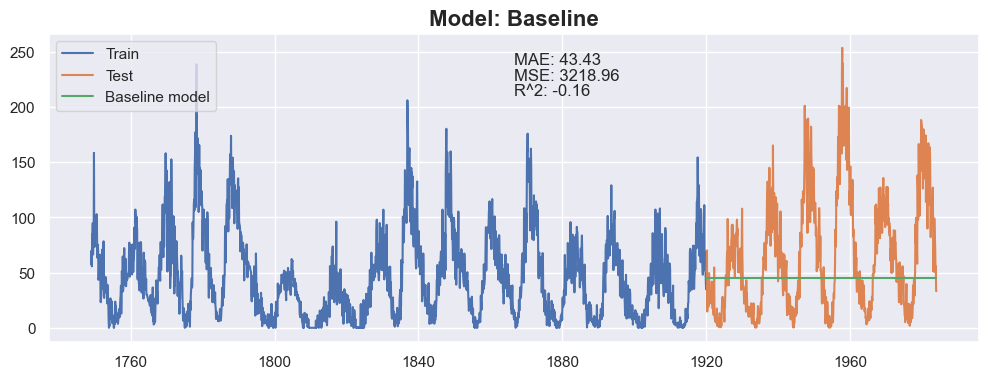

In [32]:
# Plot the baseline model
plt.figure(figsize=(12, 4))
plt.plot(df_train.index, df_train['Sunspots'], label='Train')
plt.plot(df_test.index, df_test['Sunspots'], label='Test')
plt.plot(df_test.index, baseline_model, label='Baseline model')
plt.legend(loc='upper left')

mae = mean_absolute_error(df_test, baseline_model)
mse = mean_squared_error(df_test, baseline_model)
r2 = r2_score(df_test, baseline_model)

plt.title(f"Model: Baseline", fontsize=16, fontweight='bold')

plt.text(0.5, 0.9, f"MAE: {mae:.2f}", transform=plt.gca().transAxes)
plt.text(0.5, 0.85, f"MSE: {mse:.2f}", transform=plt.gca().transAxes)
plt.text(0.5, 0.8, f"R^2: {r2:.2f}", transform=plt.gca().transAxes)

This clearly doesn't look good. Let's see if we can do better.

## Train and Compare Models

I will create the features to train the model, the month and the year.

### Features Engineering

Since the date itself is a bad feature, I need to create them, to train the model:

- The month: a number between 1 and 12 that indicates the month of the year.
- The partial: a number between 0 and 133 that indicate the month of the cycle. The cycle is 134.29 months long, so the partial is the number of months since the last cycle.
- The trend: the trend is the long-term increase or decrease in the data. It is the overall pattern of the data. It is the trend that the model will try to predict.
- The noise: the noise is the difference between the actual observation and the prediction of the previous model. It is the noise around the trend and seasonal component.
- The seasonality: the seasonality is the periodic component of the data. It is the repeating pattern within each year.

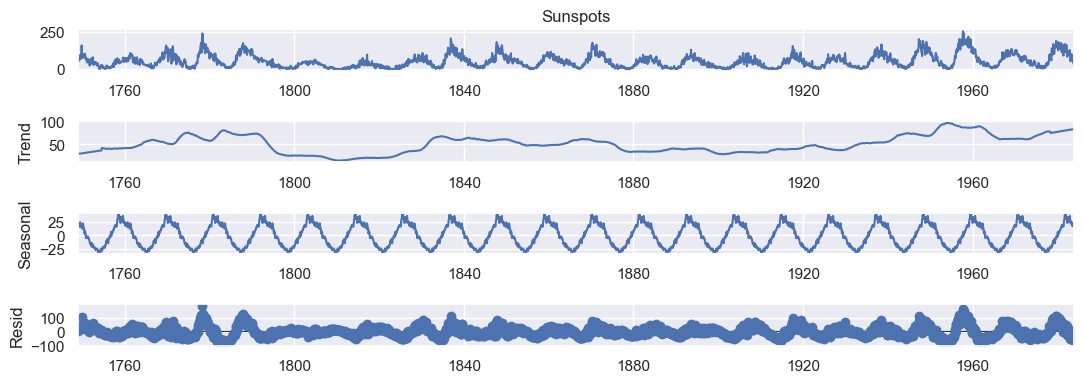

In [33]:
plt_seasonal_dec = seasonal_decompose(df_indexed['Sunspots'], model='additive', period=134, extrapolate_trend='freq', two_sided=True).plot()

In [34]:
df_train = df_indexed['1749-01-01':'1919-12-01']
df_test = df_indexed['1920-01-01':'1983-12-01']

def parse_df(df_: pd.DataFrame, trend_period: int = 137, seasonal_period: int = 12, window_size: int = 3) -> pd.DataFrame:
    df_ret = pd.DataFrame(columns=[#'Month-total', # The month number since the beginning of the data (preserve total time information)
                                    # 'Partial-trend-month', # The month number since the beginning of the cycle
                                    # 'Partial-seasonal-month', # The month number since the beginning of the seasonality
                                    # 'rolling-avg-3', # The rolling average, gives information about the sunspots numbers
                                    # 'rolling_change', # The rolling difference, gives information about the direction
                                    # 'Trend',
                                    # 'Noise',
                                    # 'Seasonality'
                                   ])

    # df_ret['Month-total'] = df_.index.month + (df_.index.year - 1749) * 12
    df_ret['Partial-trend-month'] = ((df_.index.year - 1749) * 12 + df_.index.month) % trend_period
    df_ret['Partial-seasonal-month'] = ((df_.index.year - 1749) * 12 + df_.index.month) % seasonal_period

    rolling_avg = df_['Sunspots'].rolling(window=3, min_periods=1).mean().to_frame()['Sunspots']

    rolling_diff = df_['Sunspots'].diff(periods=1).to_frame()['Sunspots']
    rolling_diff.fillna(0, inplace=True)

    df_ret.index = df_.index

    # to add the information about the speed of the change
    # I wanted to get the rolling derivative or the gradient, but there is no function for that, however,
    # I found out the percentage change function (only version 2.0.1+)
    # which gives the percentage change between the current and a prior element(s). (it doesn't work)
    # rolling_change = df_['Sunspots'].pcnt_change(window_size)

    # I will calculate simply by doing: Dy/Dx where x is the time and y is the sunspots
    # print i will use 3 month as the time step
    # rolling sum of the last 3 months
    rolling_der = df_['Sunspots'].diff(periods=1).to_frame()['Sunspots']
    # fill the first 2 values with the first value 1
    rolling_der.fillna(1, inplace=True)
    # calculate the derivative
    rolling_der = rolling_der/3

    seasonal_decompose_result = seasonal_decompose(df_['Sunspots'], model='additive', period=134, extrapolate_trend='freq', two_sided=True)

    for idx, row in df_ret.iterrows():
        # df_ret.at[idx, 'rolling-avg-3'] = rolling_avg.at[idx]
        df_ret.at[idx, 'rolling-diff'] = rolling_diff.at[idx]
        df_ret.loc[idx, 'rolling-der'] = rolling_der.at[idx]
        df_ret.loc[idx, 'Trend'] = seasonal_decompose_result.trend[idx]
        df_ret.loc[idx, 'Seasonality'] = seasonal_decompose_result.seasonal[idx]
        df_ret.loc[idx, 'Noise'] = seasonal_decompose_result.resid[idx]

    return df_ret

X_train = parse_df(df_train)
X_test = parse_df(df_test)

# as y, use the next month sunspots
y_train = df_train['Sunspots'].shift(-1).dropna()
y_test = df_test['Sunspots'].shift(-1).dropna()

 # count null
X_train.head()

Partial-trend-month  Partial-seasonal-month  rolling-diff  \
Month                                                                   
1749-01-01                    1                       1           0.0   
1749-02-01                    2                       2           4.6   
1749-03-01                    3                       3           7.4   
1749-04-01                    4                       4         -14.3   
1749-05-01                    5                       5          29.3   

            rolling-der      Trend  Seasonality      Noise  
Month                                                       
1749-01-01     0.333333  29.467287    25.208104   3.324609  
1749-02-01     1.533333  29.579665    21.201296  11.819039  
1749-03-01     2.466667  29.692042    25.258995  15.048963  
1749-04-01    -4.766667  29.804420    20.716833   5.178747  
1749-05-01     9.766667  29.916798    20.874531  34.208671

### Compare Models


In [35]:
def predict_next(months: int, df_X_train: pd.DataFrame(), df_y_train: pd.DataFrame() , model_: sklearn.linear_model) -> pd.DataFrame():
    df_y_train = pd.DataFrame(df_y_train, columns=['Sunspots'])

    # I will use the last row of the train set as the first prediction input
    for i in range(months):
        # this value correspond to the next month
        sunspot_pred = model_.predict( df_X_train.tail(1) )

        # get the last date of the df_train and add one month
        last_date = df_train.tail(1).index + pd.DateOffset(months=1)

        # create a df, date as index and prediction as value to the prediction set
        row_pred = pd.DataFrame(data=[sunspot_pred], columns=df_y_train.columns , index=last_date)

        # add the prediction row at the at to the prediction set in the only column
        df_y_train = pd.concat([df_y_train, row_pred])

        # also, prepend the very first sunspot that has been removed with the shift
        first_sunspot = df_train['Sunspots'].head(1)
        first_sunspot = pd.DataFrame(first_sunspot, columns=['Sunspots'])

        df_y_train = pd.concat([first_sunspot, df_y_train])

        # create the new dataframe for the prediction set based on the new prediction
        df_X_train = parse_df(df_y_train)

        # then shift y again
        df_y_train = df_y_train.shift(-1).dropna()

    return df_y_train[-months:]

C:\ProgramData\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


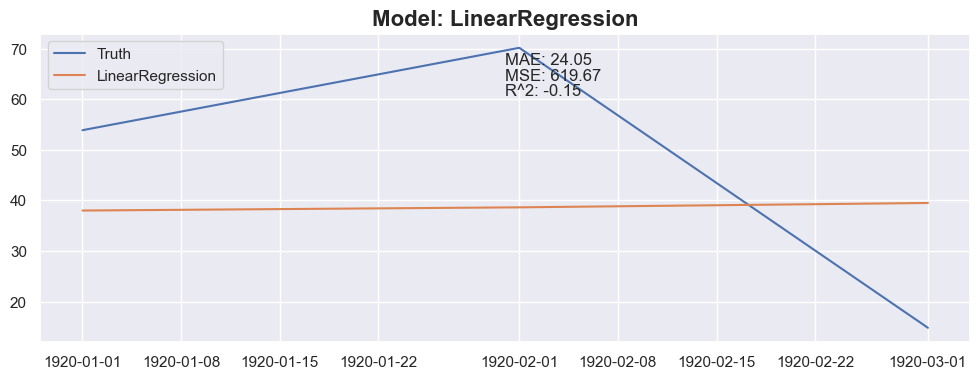

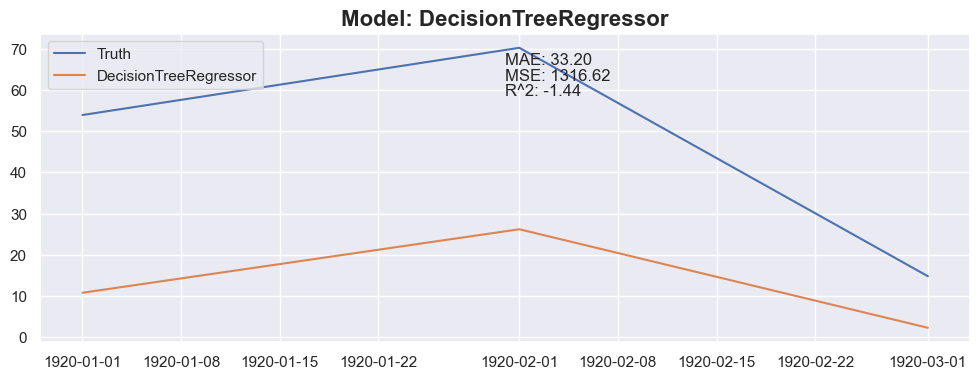

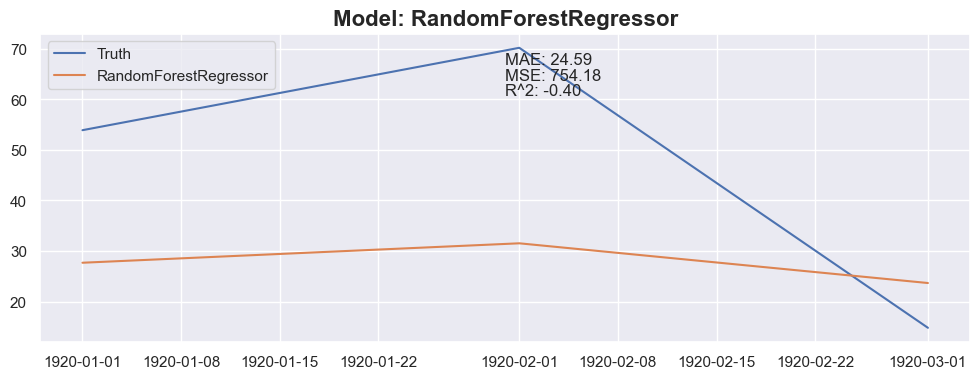

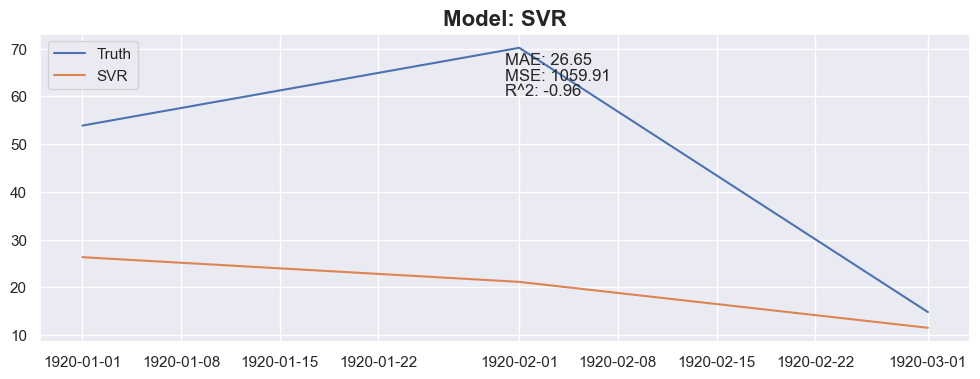

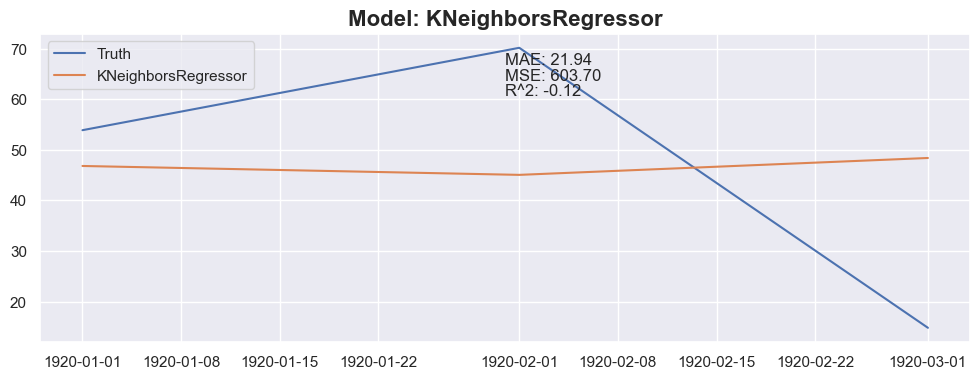

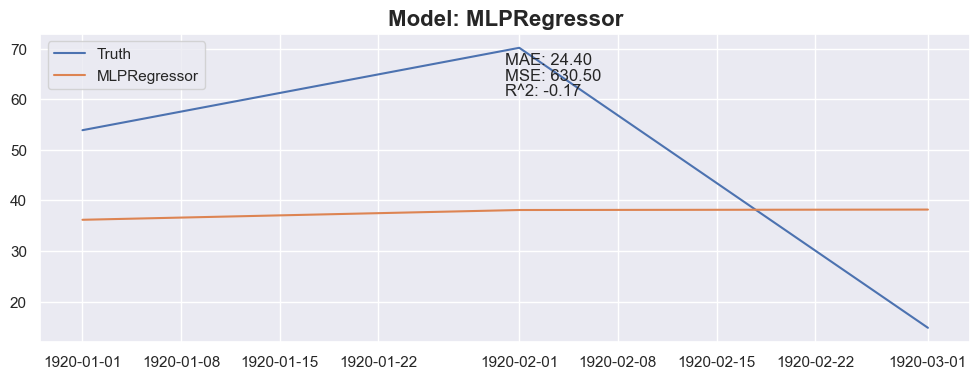

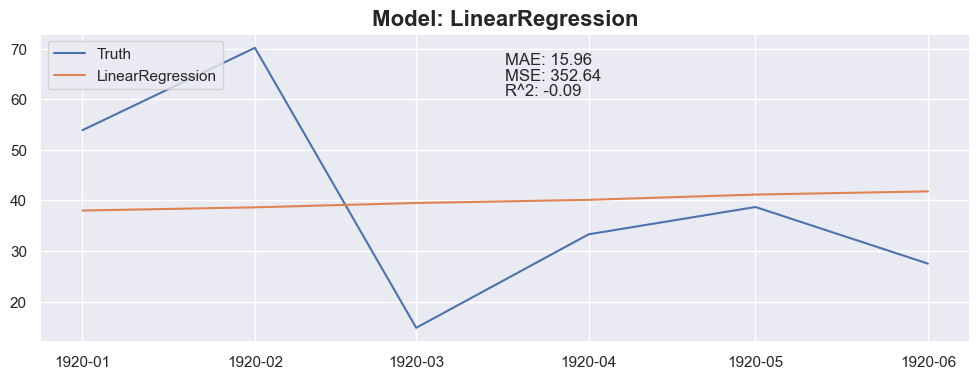

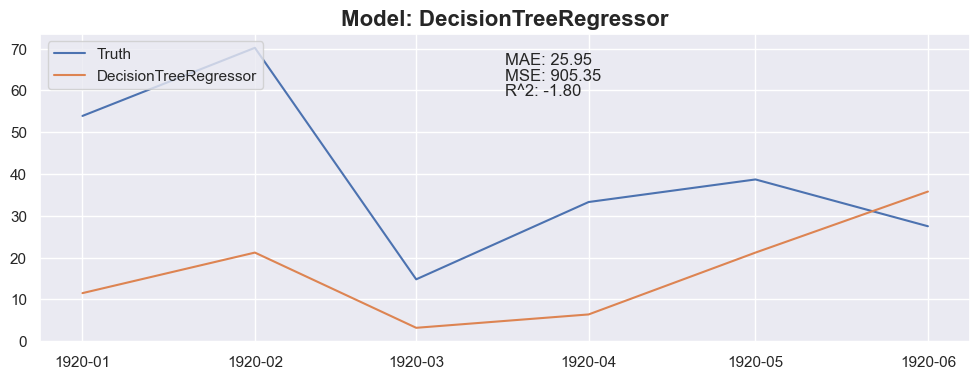

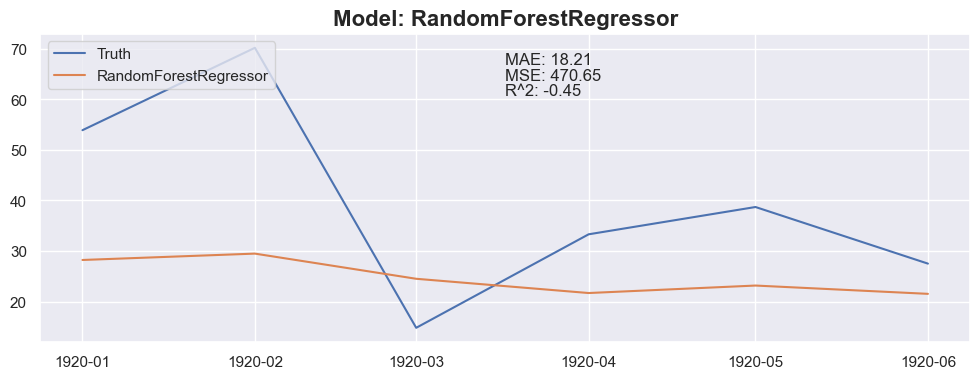

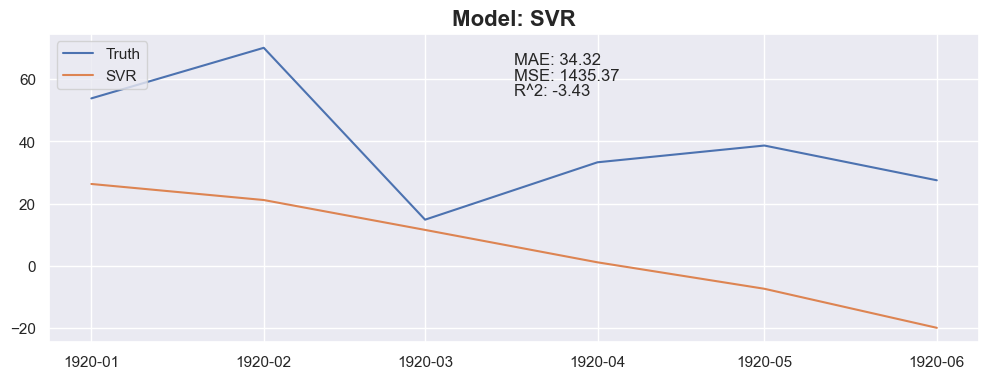

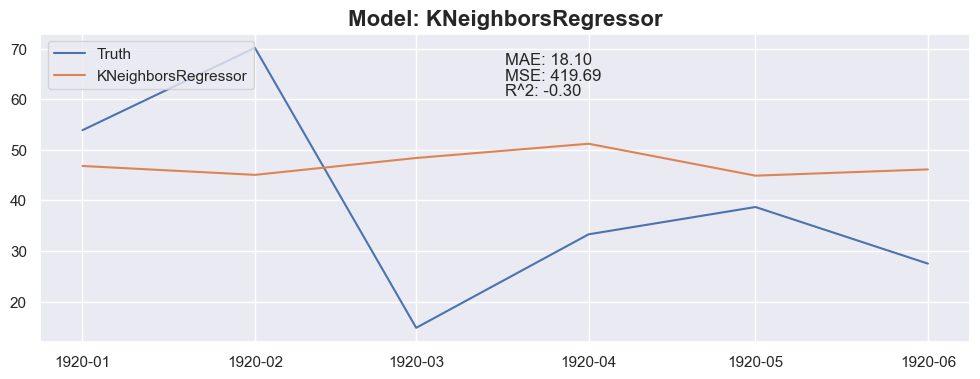

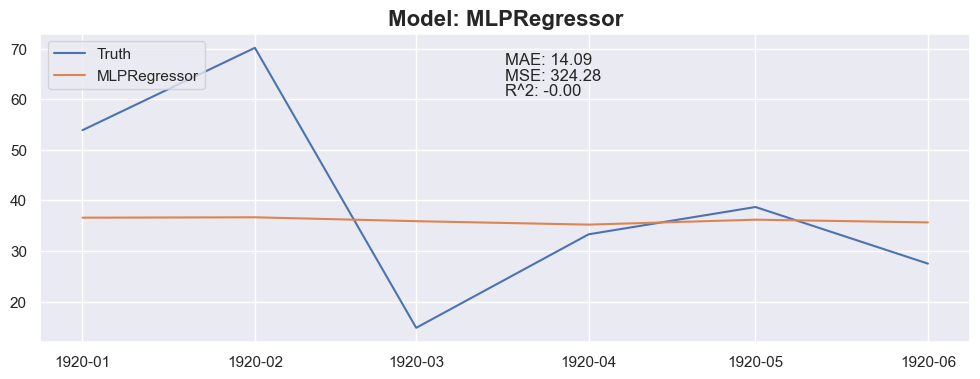

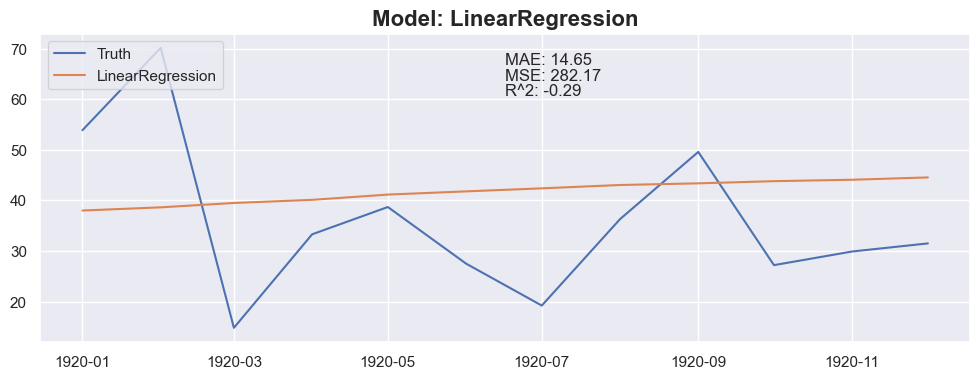

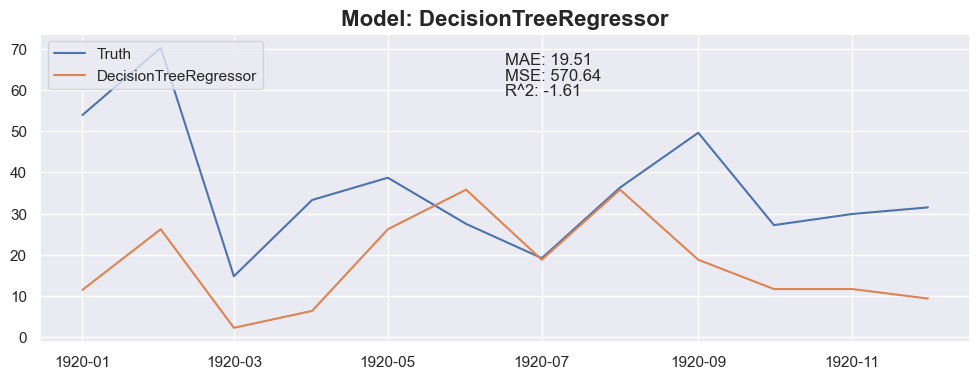

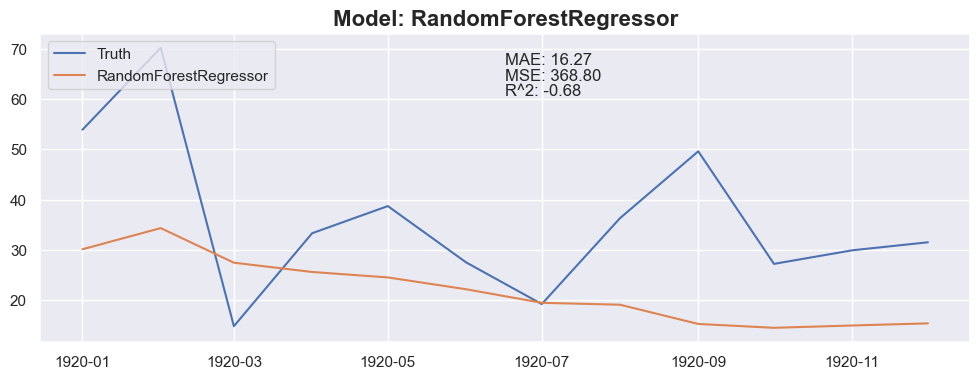

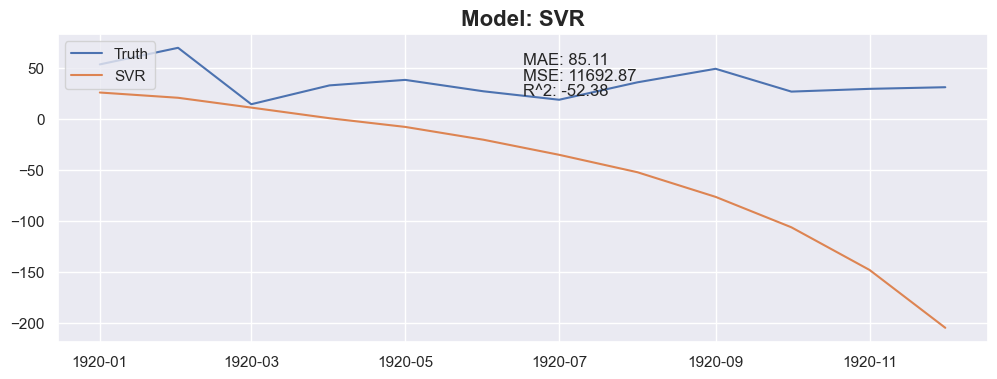

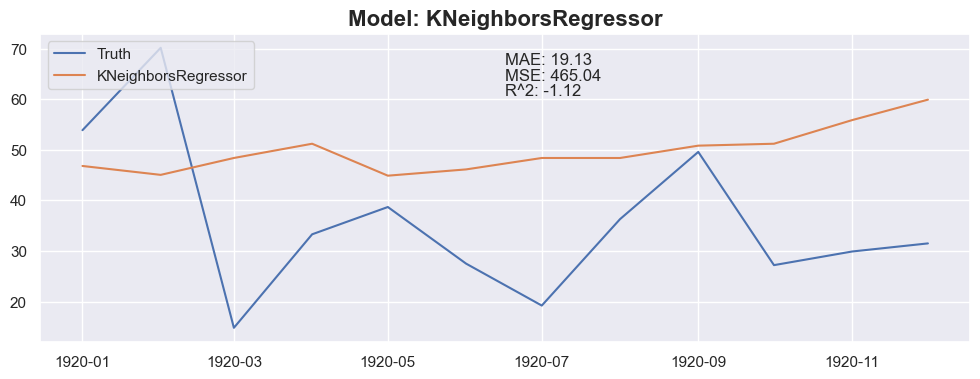

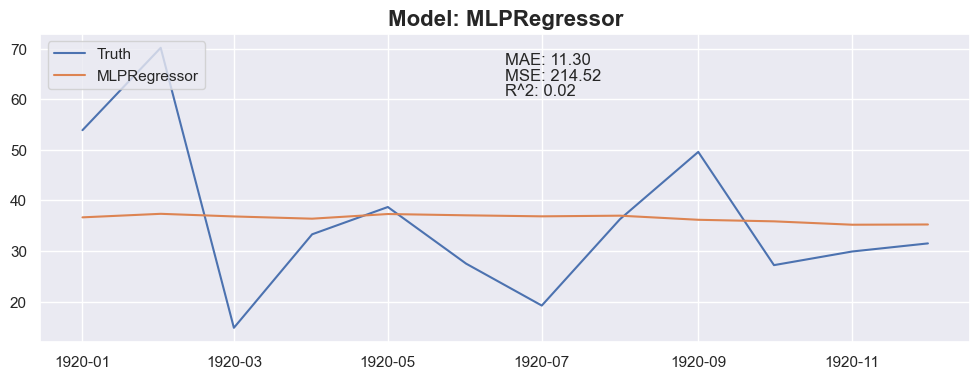

In [36]:
import sklearn


# Models to use
models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    SVR(kernel='poly'), # SVM regressor
    KNeighborsRegressor(),
    MLPRegressor(),
]

months_to_predict_array = [3, 6, 12]

for months_to_predict in months_to_predict_array:
    for model in models:

        X_train_model = X_train.copy()
        X_test_model = X_test.copy()
        y_train_model = y_train.copy()
        y_test_model = y_test.copy()

        # fit the model, don't use the last row since has no truth
        model = model.fit(X_train_model[:-1], y_train_model)

        model_name = model.__class__.__name__

        y_pred = predict_next(months_to_predict, X_train_model, y_train_model, model)

        plt.figure(figsize=(12, 4))
        # plt.plot(X_train_model[:-1].index, y_train_model, label='Train')
        plt.plot(X_test_model[:months_to_predict].index, y_test_model[:months_to_predict], label='Truth')
        plt.plot(X_test_model[:months_to_predict].index, y_pred, label=model_name)
        plt.legend(loc='upper left')

        mae = mean_absolute_error(y_test_model[:months_to_predict], y_pred)
        mse = mean_squared_error(y_test_model[:months_to_predict], y_pred)
        r2 = r2_score(y_test_model[:months_to_predict], y_pred)

        plt.title(f"Model: {model_name}", fontsize=16, fontweight='bold')

        plt.text(0.5, 0.9, f"MAE: {mae:.2f}", transform=plt.gca().transAxes)
        plt.text(0.5, 0.85, f"MSE: {mse:.2f}", transform=plt.gca().transAxes)
        plt.text(0.5, 0.8, f"R^2: {r2:.2f}", transform=plt.gca().transAxes)

### Conclusion

The linear regression with default value has a perfect score, so I think I could be happy with this result and stop here.

# Optional : Darts

Tring using the [Darts library](https://unit8.com/resources/darts-time-series-made-easy-in-python/).

In [37]:
from darts import TimeSeries

In [38]:
df_darts = pd.read_csv('data/monthly-sunspots.csv')
df_darts.head()

Month  Sunspots
0  1749-01      58.0
1  1749-02      62.6
2  1749-03      70.0
3  1749-04      55.7
4  1749-05      85.0

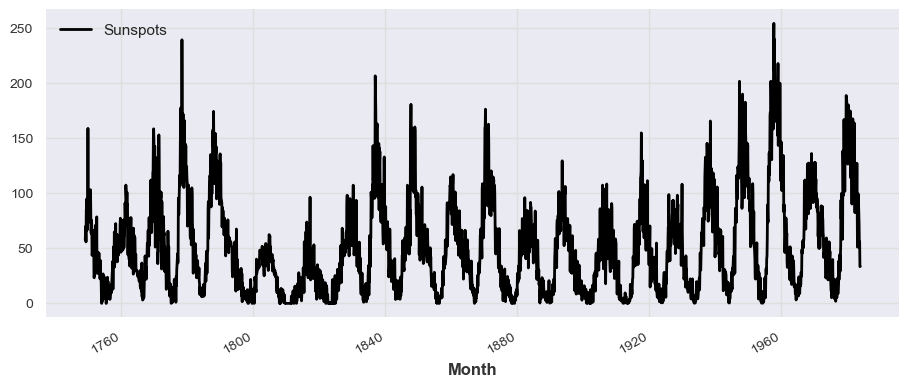

In [39]:
series = TimeSeries.from_dataframe(df_darts, 'Month', 'Sunspots')
series.plot()

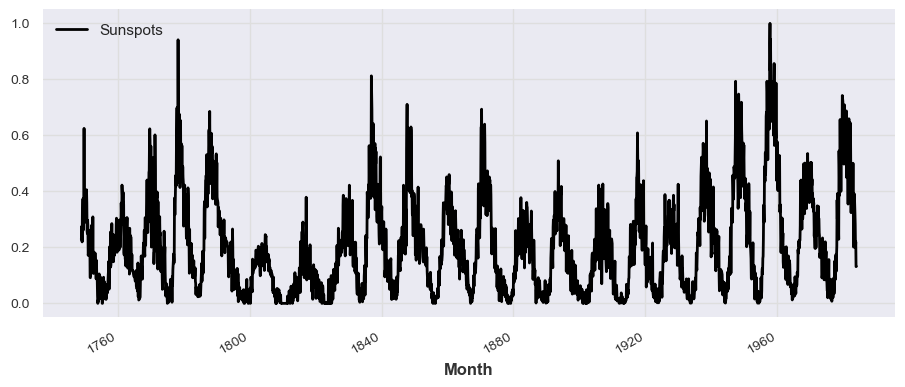

In [40]:
from darts.dataprocessing.transformers import Scaler

scaler = Scaler()
series_scaled = scaler.fit_transform(series)
series_scaled.plot()

## Splitting the series

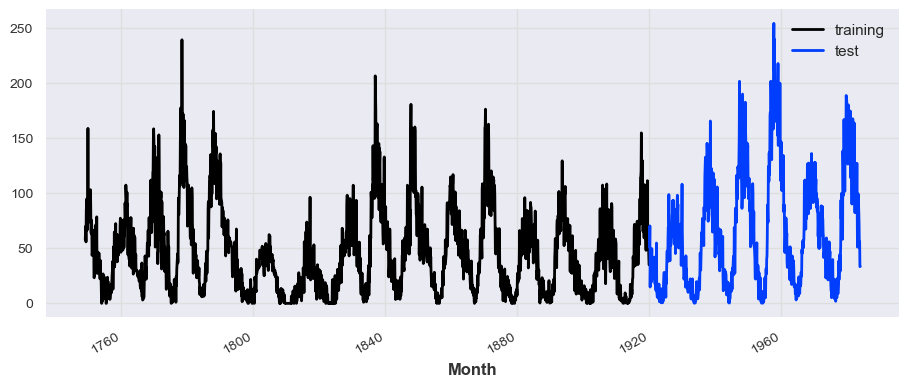

In [41]:
train_series, test_series = series.split_before(pd.Timestamp('19200101'))

train_series.plot(label='training')
test_series.plot(label='test')

## Missing values

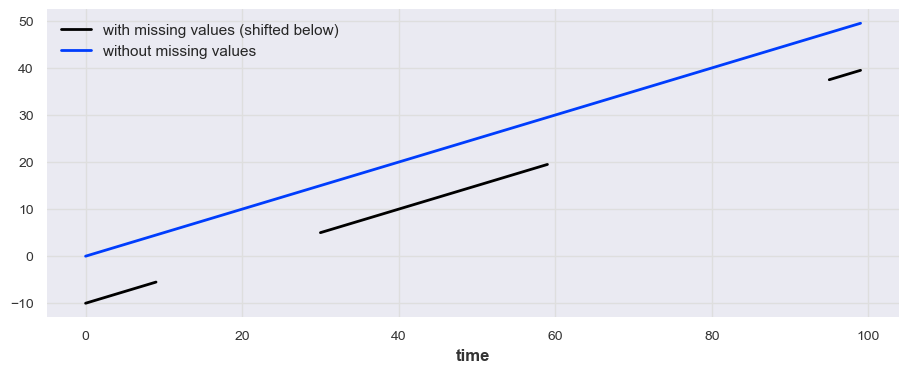

In [42]:
# example code
from darts.utils.missing_values import fill_missing_values

values = np.arange(50, step=0.5)
values[10:30] = np.nan
values[60:95] = np.nan
series_ = TimeSeries.from_values(values)

(series_ - 10).plot(label="with missing values (shifted below)")
fill_missing_values(series_).plot(label="without missing values")

## Train and predict

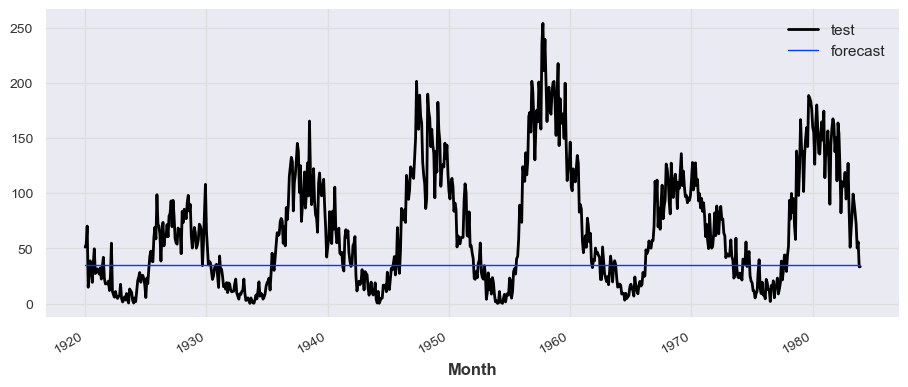

In [43]:
from darts.models import NaiveSeasonal

model = NaiveSeasonal(K=1)
model.fit(train_series)

prediction = model.predict(len(test_series))

# train_series.plot(label='actual')
test_series.plot(label='test')
prediction.plot(label='forecast', lw=1)
plt.legend()

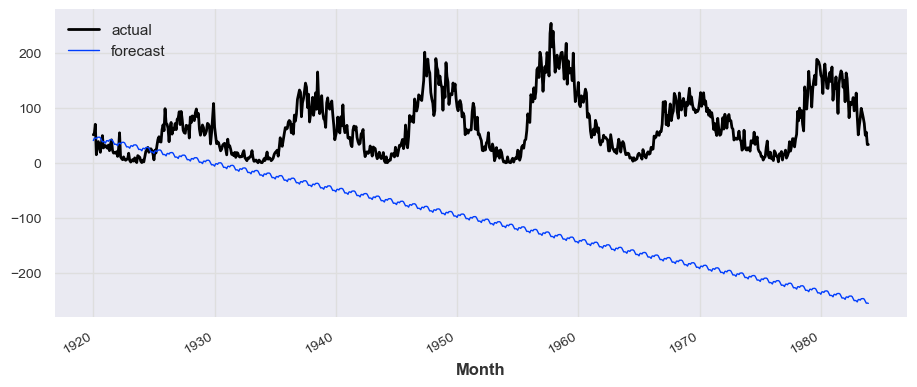

In [51]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing()
model.fit(train_series)
prediction_exp = model.predict(len(test_series))

# train_series.plot(label='actual')
test_series.plot(label='actual')
prediction_exp.plot(label='forecast', lw=1)

plt.legend()

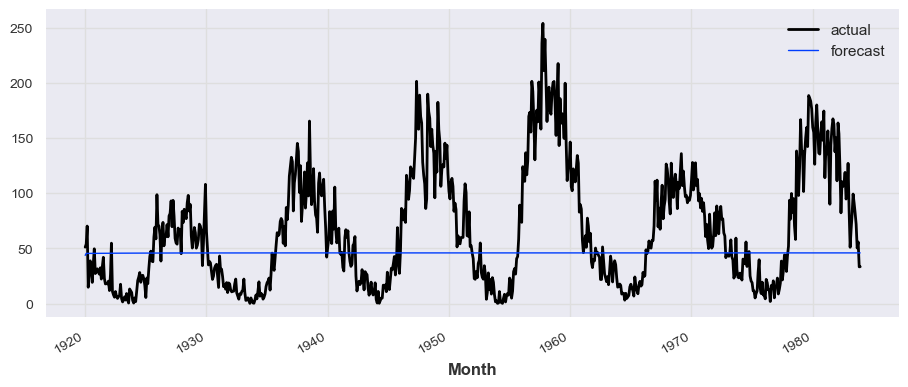

In [52]:
from darts.models import AutoARIMA

model_aarima = AutoARIMA()
model_aarima.fit(train_series)
prediction_aarima = model_aarima.predict(len(test_series))

# train_series.plot(label='actual')
test_series.plot(label='actual')
prediction_aarima.plot(label='forecast', lw=1)

plt.legend()

08:29:59 - cmdstanpy - INFO - Chain [1] start processing
08:29:59 - cmdstanpy - INFO - Chain [1] done processing


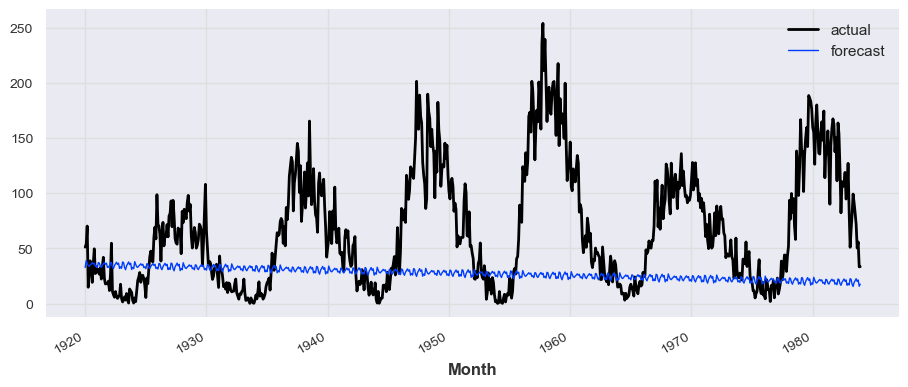

In [53]:
from darts.models import Prophet

model_prophet = Prophet()
model_prophet.fit(train_series)
prediction_prophet = model_prophet.predict(len(test_series))

# train_series.plot(label='actual')
test_series.plot(label='actual')
prediction_prophet.plot(label='forecast', lw=1)

plt.legend()

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | V             | Linear           | 26    
---------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

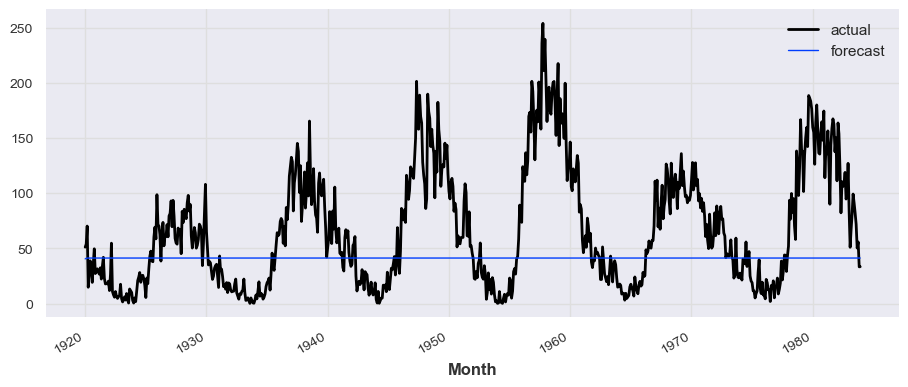

In [47]:
from darts.models import RNNModel, TCNModel, TransformerModel

model_rnn = RNNModel( input_chunk_length=12, output_chunk_length=1, n_epochs=30, model_name='LSTM')
model_rnn.fit(train_series, verbose=True)
prediction_rnn = model_rnn.predict(len(test_series))

# train_series.plot(label='actual')
test_series.plot(label='actual')
prediction_rnn.plot(label='forecast', lw=1)

plt.legend()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 92    
----------------------------------------------------
92        Trainable params
0         Non-trainable params
92        Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

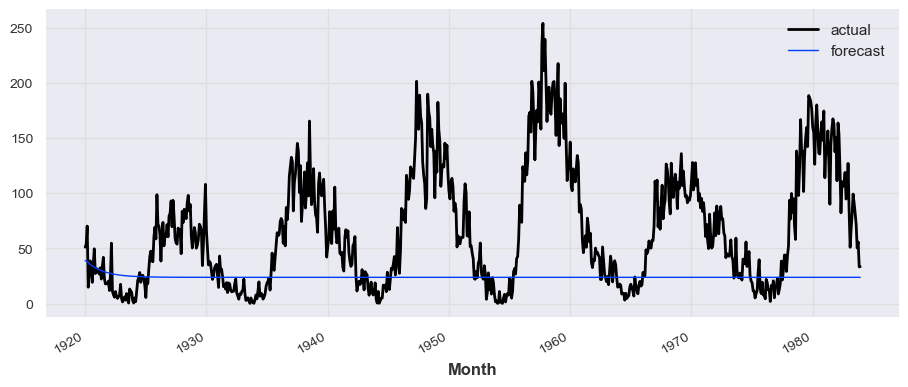

In [54]:
model_tcn = TCNModel(input_chunk_length=12, output_chunk_length=1, n_epochs=30)
model_tcn.fit(train_series, verbose=True)
prediction_tcn = model_tcn.predict(len(test_series))

# train_series.plot(label='actual')
test_series.plot(label='actual')
prediction_tcn.plot(label='forecast', lw=1)

plt.legend()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 128   
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 548 K 
6 | decoder             | Linear              | 65    
------------------------------------------------------------
548 K     Trainable params
0         Non-trainable params
548 K     Total params
2.195     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

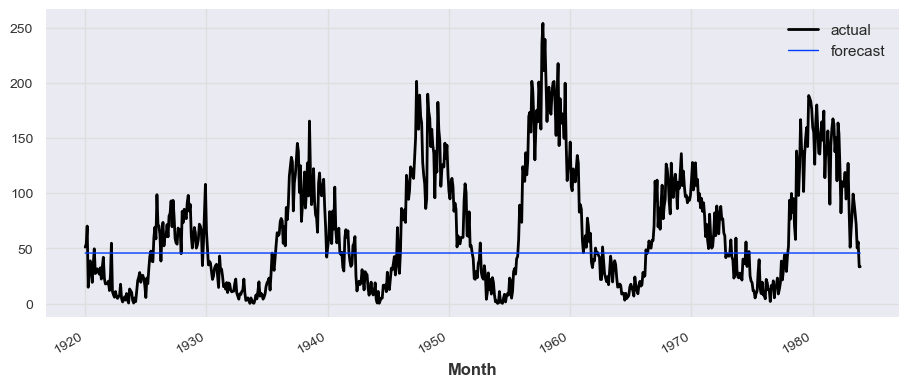

In [55]:
model_transformer = TransformerModel(input_chunk_length=12, output_chunk_length=1, n_epochs=30)
model_transformer.fit(train_series, verbose=True)
prediction_transformer = model_transformer.predict(len(test_series))

# train_series.plot(label='actual')
test_series.plot(label='actual')
prediction_transformer.plot(label='forecast', lw=1)

plt.legend()

## Evaluation

In [62]:
from darts.metrics import mape, mase

print('Prophet')
print('MAPE: {:.2f}%'.format(mape(prediction_prophet, test_series)))
print('MASE: {:.2f}'.format(mase(prediction_prophet, test_series, train_series)))
print('R^2: {:.2f}'.format(r2_score(test_series.values(), prediction_prophet.values())))

print('AutoARIMA')
print('MAPE: {:.2f}%'.format(mape(prediction_aarima, test_series)))
print('MASE: {:.2f}'.format(mase(prediction_aarima, test_series, train_series)))
print('R^2: {:.2f}'.format(r2_score(test_series.values(), prediction_aarima.values())))

print('Exponential Smoothing')
print('MAPE: {:.2f}%'.format(mape(prediction_exp, test_series)))
print('MASE: {:.2f}'.format(mase(prediction_exp, test_series, train_series)))
print('R^2: {:.2f}'.format(r2_score(test_series.values(), prediction_exp.values())))

print('RNN')
print('MAPE: {:.2f}%'.format(mape(prediction_rnn, test_series)))
print('MASE: {:.2f}'.format(mase(prediction_rnn, test_series, train_series)))
print('R^2: {:.2f}'.format(r2_score(test_series.values(), prediction_rnn.values())))

print('TCN')
print('MAPE: {:.2f}%'.format(mape(prediction_tcn, test_series)))
print('MASE: {:.2f}'.format(mase(prediction_tcn, test_series, train_series)))
print('R^2: {:.2f}'.format(r2_score(test_series.values(), prediction_tcn.values())))

print('Transformer')
print('MAPE: {:.2f}%'.format(mape(prediction_transformer, test_series)))
print('MASE: {:.2f}'.format(mase(prediction_transformer, test_series, train_series)))
print('R^2: {:.2f}'.format(r2_score(test_series.values(), prediction_transformer.values())))

Prophet
MAPE: 195.49%
MASE: 4.25
R^2: -0.62
AutoARIMA
MAPE: 94.51%
MASE: 3.76
R^2: -0.16
Exponential Smoothing
MAPE: 558.50%
MASE: 15.00
R^2: -14.13
RNN
MAPE: 106.90%
MASE: 3.83
R^2: -0.23
TCN
MAPE: 207.13%
MASE: 4.29
R^2: -0.67
Transformer
MAPE: 94.76%
MASE: 3.77
R^2: -0.16
